In [2]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns

# This specific command allows graphs to show up directly below your code
%matplotlib inline 

# Set a nice style for the plots
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = (14, 6)

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [3]:
def load_and_merge_data(data_folder='data'):
    # Find all csv files in the data folder
    file_pattern = os.path.join(data_folder, "*.csv")
    files = glob.glob(file_pattern)
    
    if not files:
        print("ERROR: No CSV files found in 'data/' folder.")
        return None
    
    print(f"Found {len(files)} files. Merging...")
    
    # Read and merge
    dfs = [pd.read_csv(f) for f in files]
    merged_df = pd.concat(dfs, ignore_index=True)
    
    # Convert timestamp to datetime and sort
    merged_df['timestamp'] = pd.to_datetime(merged_df['timestamp'])
    merged_df = merged_df.sort_values('timestamp').reset_index(drop=True)
    
    return merged_df

# Run the function
df = load_and_merge_data()

# Show the first 5 rows to check if it worked
df.head()

Found 7 files. Merging...


,timestamp,temperature,humidity,light,pH,electrical_conductivity
0,2025-03-01 00:00:00,24.69,52.66,118.65,6.68,0.996
1,2025-03-01 00:00:05,21.89,50.18,801.71,7.29,1.044
2,2025-03-01 00:00:10,23.88,48.01,682.39,7.66,1.354
3,2025-03-01 00:00:15,20.42,56.73,146.05,7.77,0.519
4,2025-03-01 00:00:20,20.79,41.54,106.87,7.77,1.900


In [4]:
# 1. Basic Statistics
print("--- Basic Statistics ---")
display(df.describe())

# 2. Variance per Sensor (Required by Assignment Task 1.3)
print("\n--- Variance (Volatility) per Sensor ---")
variance = df[['temperature', 'humidity', 'light', 'pH', 'electrical_conductivity']].var()
print(variance)

--- Basic Statistics ---


,timestamp,temperature,humidity,light,pH,electrical_conductivity
count,120960,120960.000000,120960.000000,120960.000000,120960.000000,120960.000000
mean,2025-03-04 11:59:57.499999744,22.500301,50.026163,549.103790,7.000135,1.249303
min,2025-03-01 00:00:00,20.000000,40.000000,100.000000,6.000000,0.500000
25%,2025-03-02 17:59:58.750000128,21.250000,45.050000,323.670000,6.500000,0.875000
50%,2025-03-04 11:59:57.500000,22.500000,50.060000,548.910000,7.000000,1.249000
75%,2025-03-06 05:59:56.249999872,23.750000,55.010000,773.690000,7.500000,1.625000
max,2025-03-07 23:59:55,25.000000,60.000000,999.990000,8.000000,2.000000
std,NaN,1.442144,5.766784,259.726259,0.576866,0.433405



--- Variance (Volatility) per Sensor ---
temperature                    2.079780
humidity                      33.255800
light                      67457.729719
pH                             0.332774
electrical_conductivity        0.187840
dtype: float64


In [5]:
# 1. Label Day vs Night (Light Threshold > 300 means Day)
df['period'] = df['light'].apply(lambda x: 'Daytime' if x > 300 else 'Nighttime')

# 2. Calculate Rolling Averages (Window = 720 readings approx 1 hour)
window_size = 720 
df['temp_moving_avg'] = df['temperature'].rolling(window=window_size).mean()
df['humid_moving_avg'] = df['humidity'].rolling(window=window_size).mean()

# Show the new columns
df[['timestamp', 'light', 'period', 'temp_moving_avg']].head()

,timestamp,light,period,temp_moving_avg
0,2025-03-01 00:00:00,118.65,Nighttime,NaN
1,2025-03-01 00:00:05,801.71,Daytime,NaN
2,2025-03-01 00:00:10,682.39,Daytime,NaN
3,2025-03-01 00:00:15,146.05,Nighttime,NaN
4,2025-03-01 00:00:20,106.87,Nighttime,NaN


In [8]:
# ==========================================
# INJECTING ARTIFICIAL ANOMALIES (For Demonstration)
# ==========================================
# Let's simulate a "Cooling System Failure" on Day 3 (March 3rd)
# We will force the temperature to spike up to 35-40 degrees for a short time.

# Find the index for a time on March 3rd
spike_start = 20000  # Arbitrary index around day 3
spike_end = 20200    # Duration of the fault

# Inject the spike
df.loc[spike_start:spike_end, 'temperature'] += 15 

# Let's simulate a "Sensor Disconnect" (Drop to 0) on Day 5
drop_start = 50000
drop_end = 50050
df.loc[drop_start:drop_end, 'temperature'] = 0

print("Artificial anomalies injected! Now run the next cell to detect them.")

Artificial anomalies injected! Now run the next cell to detect them.


In [9]:
# Define window for local context (e.g., 5 minutes = 60 readings)
window = 60

# Calculate Rolling Mean and Std Dev for Temperature
rolling_mean = df['temperature'].rolling(window=window).mean()
rolling_std = df['temperature'].rolling(window=window).std()

# Define Upper and Lower limits (3 Standard Deviations)
df['upper_bound'] = rolling_mean + (3 * rolling_std)
df['lower_bound'] = rolling_mean - (3 * rolling_std)

# Identify Anomalies
df['is_anomaly'] = ((df['temperature'] > df['upper_bound']) | 
                    (df['temperature'] < df['lower_bound']))

# Count how many we found
print(f"Total Anomalies Detected: {df['is_anomaly'].sum()}")

Total Anomalies Detected: 15


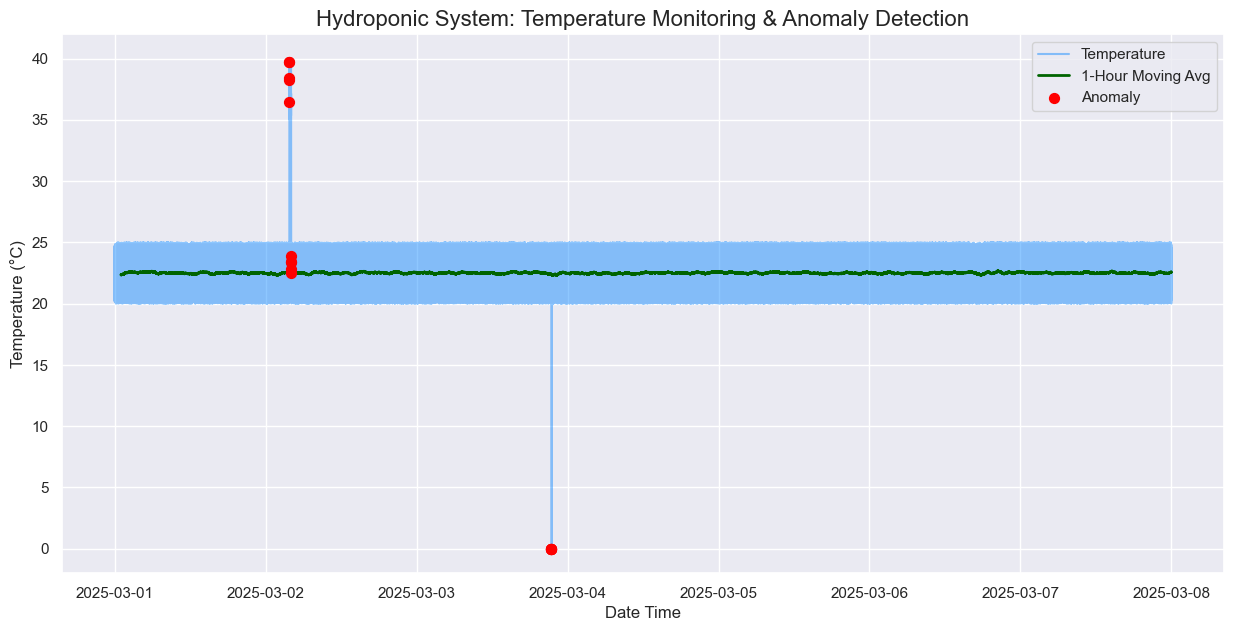

In [10]:
plt.figure(figsize=(15, 7))

# Plot raw temperature (light blue)
plt.plot(df['timestamp'], df['temperature'], label='Temperature', color='dodgerblue', alpha=0.5)

# Plot Moving Average (green)
plt.plot(df['timestamp'], df['temp_moving_avg'], label='1-Hour Moving Avg', color='darkgreen', linewidth=2)

# Plot Anomalies (red dots)
anomalies = df[df['is_anomaly']]
plt.scatter(anomalies['timestamp'], anomalies['temperature'], color='red', label='Anomaly', s=50, zorder=5)

plt.title('Hydroponic System: Temperature Monitoring & Anomaly Detection', fontsize=16)
plt.xlabel('Date Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()